In [57]:
import os
import time
import torch
import torchaudio
import pandas as pd
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from tqdm import tqdm
import matplotlib.pyplot as plt
import evaluate


metric = evaluate.load("wer")
def compute_metrics(pred, processor):
    pred_ids = pred["predictions"]
    label_ids = pred["label_ids"]
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    pred_str = [p.lower() for p in pred_str]
    label_str = [l.lower() for l in label_str]
    wer = 100 * metric.compute(predictions=pred_str, references=label_str)
    return {"eval_wer": wer}


def transcribe_samples(model, processor, samples):
    results = []
    times = []
    predictions = []
    references = []
    wer_list = []

    for sample in tqdm(samples, desc=f"Transcribing Samples", unit="sample"):
        waveform, sample_rate = torchaudio.load(sample["file_path"])
        if sample_rate != processor.feature_extractor.sampling_rate:
            resampler = torchaudio.transforms.Resample(sample_rate, processor.feature_extractor.sampling_rate)
            waveform = resampler(waveform)
        input_features = processor(waveform.squeeze(0), sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt").input_features

        reference_str = sample["reference"]

        start_time = time.time()
        pred_ids = model.generate(input_features)
        pred_str = processor.decode(pred_ids[0], skip_special_tokens=True)
        end_time = time.time()

        predictions.append(pred_str)
        references.append(reference_str)
        times.append(end_time - start_time)

        pred = {
            "predictions": processor.tokenizer(pred_str, return_tensors="pt", padding=True, truncation=True).input_ids,
            "label_ids": processor.tokenizer(reference_str, return_tensors="pt", padding=True, truncation=True).input_ids,
        }
        metrics = compute_metrics(pred, processor)
        wer_list.append(metrics["eval_wer"])

        results.append({"reference": reference_str, "transcription": pred_str})

    return results, times, wer_list, predictions, references

def evaluate_models(model_paths, samples):
    results = {}
    times_all = {}
    wer_all = {}

    for model_path in model_paths:
        processor = WhisperProcessor.from_pretrained(model_path, language="pl", task="transcribe")
        model = WhisperForConditionalGeneration.from_pretrained(model_path)
        model.config.forced_decoder_ids = processor.get_decoder_prompt_ids(language="pl", task="transcribe")

        transcriptions, times, wer_list, predictions, references = transcribe_samples(model, processor, samples)

        overall_pred = {
            "predictions": processor.tokenizer(predictions, padding=True, truncation=True, return_tensors="pt").input_ids,
            "label_ids": processor.tokenizer(references, padding=True, truncation=True, return_tensors="pt").input_ids,
        }
        overall_metrics = compute_metrics(overall_pred, processor)

        results[model_path] = overall_metrics["eval_wer"]
        times_all[model_path] = times
        wer_all[model_path] = wer_list

    return results, times_all, wer_all


def plot_inference_times_and_wer(times_all, wer_all):
    model_names = list(times_all.keys())
    all_times = [times_all[model_path] for model_path in model_names]

    # WER
    plt.figure(figsize=(10, 6))
    wer_values = [wer_all[model_path] for model_path in model_names]
    avg_wer = [sum(wer) / len(wer) for wer in wer_values]
    bars = plt.bar(model_names, avg_wer, color='orange')
    plt.title("WER Comparison for All Models")
    plt.xlabel("Model")
    plt.ylabel("WER (%)")
    plt.xticks(rotation=45)
    for bar, wer in zip(bars, avg_wer):
        plt.text(bar.get_x() + bar.get_width() / 2, wer / 2, f'{wer:.2f}%', 
                 ha='center', va='center', fontsize=10, color='white')
    plt.tight_layout()
    plt.show()

    # times
    plt.figure(figsize=(10, 6))
    plt.boxplot(all_times, tick_labels=model_names, patch_artist=True, boxprops=dict(facecolor="skyblue"))
    plt.title("Inference Time Comparison for All Models")
    plt.xlabel("Model")
    plt.ylabel("Inference Time (s)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [58]:
audio_folder = "clips"
data = pd.read_csv("validated.tsv", sep="\t")
samples = []
for index, row in data.iterrows():
    file_path = os.path.join(audio_folder, row["path"])
    if os.path.exists(file_path):
        samples.append({"file_path": file_path, "reference": row["sentence"]})
        
model_folders = ["openai/whisper-tiny", "openai/whisper-base", "openai/whisper-small"]
model_folders.extend([folder_name for folder_name in os.listdir() if folder_name.startswith("whisper")])
results, times_all, wer_all = evaluate_models(model_folders, samples[:10])

Transcribing Samples: 100%|██████████| 10/10 [00:04<00:00,  2.07sample/s]


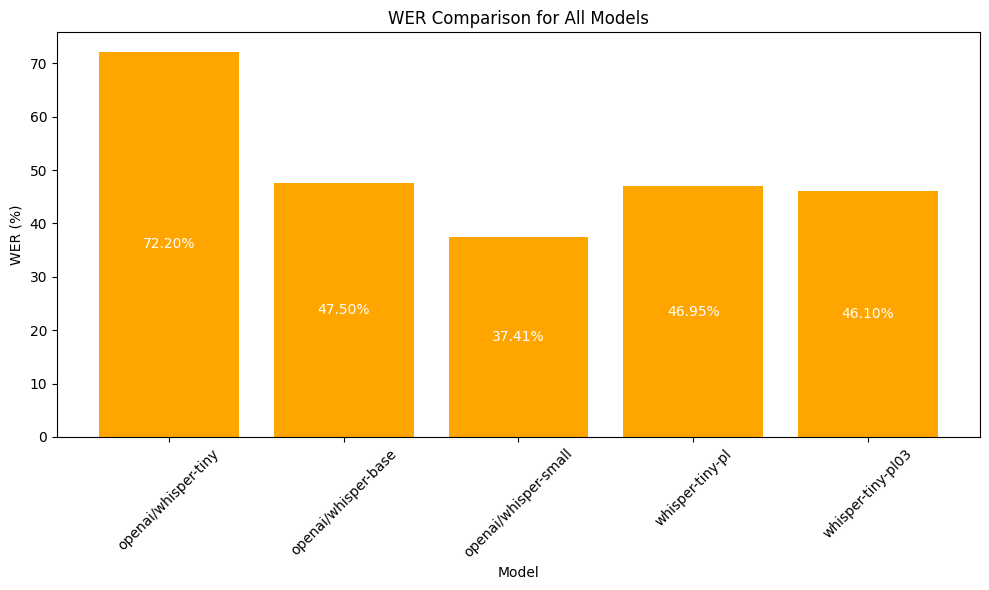

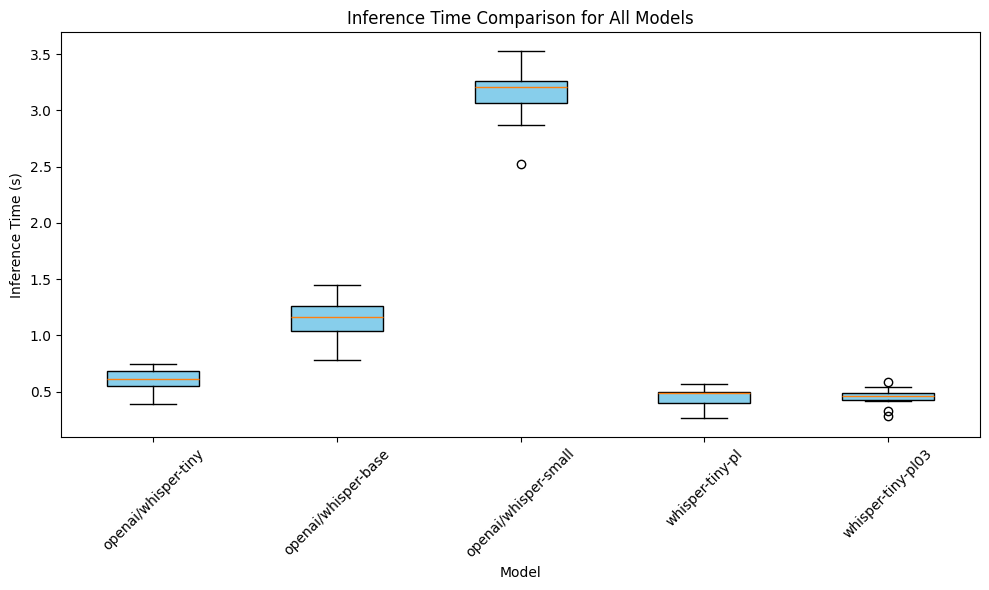

In [59]:
plot_inference_times_and_wer(times_all, wer_all)